In [34]:
import kagglehub
import matplotlib.pyplot as plt
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("shivamb/netflix-shows")

# Load the actual file (assumes it's called netflix_titles.csv)
df = pd.read_csv(os.path.join(path, "netflix_titles.csv"))

# Now verify it works
print(df.shape)
df.head()

print("Path to dataset files:", path)

(8807, 12)
Path to dataset files: /kaggle/input/netflix-shows


In [7]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [15]:
#change date_added to date_time
df['date_added'] = pd.to_datetime(df['date_added'].astype(str).str.strip(), errors='coerce')
df['missing_date_added'] = df['date_added'].isna()
df['missing_date'] = df['date_added'].isna()

In [17]:
#fill in director column missing values
df['director'] = df['director'].fillna('Unknown')

In [22]:
#fill in country column missing values
df['country'] = df['country'].fillna('Unkown')

In [25]:
#Change duration from 'seasoons' to total 'mins'
df['duration_num'] = df['duration'].str.extract('(\d+)').astype(float)

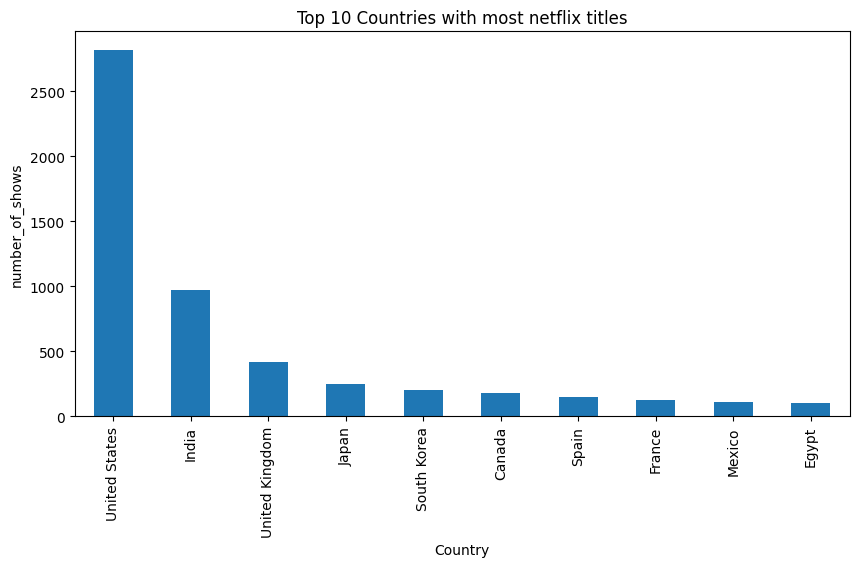

In [35]:
#Understanding what content is available in different countries
df['country'].value_counts().head(10).plot(kind='bar', figsize=(10,5))
plt.title('Top 10 Countries with most netflix titles')
plt.xlabel('Country')
plt.ylabel('number_of_shows')
plt.show()                                        

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Fill missing values in description column
df['description'] = df['description'].fillna('')

# Initialize TF-IDF vectorizer (case-sensitive fix here)
tfidf = TfidfVectorizer(stop_words='english')

# Fit and transform the descriptions into vectors
tfidf_matrix = tfidf.fit_transform(df['description'])

# Compute cosine similarity between every pair of titles
cos_sim = cosine_similarity(tfidf_matrix)

In [39]:
#Network analysis of Actors / Directors and find interesting insights
import networkx as nx
from itertools import combinations

G = nx.Graph()
for cast in df['cast'].dropna():
    people = [p.strip() for p in cast.split(',')]
    for pair in combinations(people, 2):
        if G.has_edge(*pair):
            G[pair[0]][pair[1]]['weight'] += 1
        else:
            G.add_edge(*pair, weight=1)

# Find most connected actor pairs
sorted(nx.degree(G), key=lambda x: x[1], reverse=True)[:10]


[('Anupam Kher', 273),
 ('Samuel L. Jackson', 239),
 ('Takahiro Sakurai', 228),
 ('Fred Tatasciore', 226),
 ('Yuichi Nakamura', 223),
 ('Yuki Kaji', 220),
 ('Shah Rukh Khan', 210),
 ('Fred Armisen', 209),
 ('Akshay Kumar', 193),
 ('Katsuyuki Konishi', 191)]

Text(0, 0.5, 'Count')

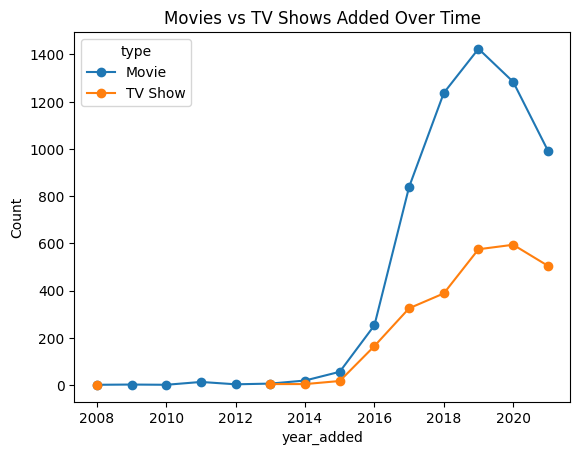

In [42]:
#Does Netflix has more focus on TV Shows than movies in recent years.
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['year_added'] = df['date_added'].dt.year
df.groupby(['year_added', 'type']).size().unstack().plot(kind='line', marker='o')
plt.title("Movies vs TV Shows Added Over Time")
plt.ylabel("Count")